# Breast Cancer Detection Using Machine Learning
This project is ddealing with mammographic images which are processed and then fed into machine learning algorithms which are trained.
Every algorithm is trained using the same training dataset
After training, the algorithms are tested independently using the testing dataset (A set of images that the algorithm has not seen before) and it's performance is determined.
The best performing algorithm is chosen for adoption.

# Importing necessary packages

In [30]:
import os
import copy
import skimage
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import skimage.feature
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn.model_selection import cross_validate

In [31]:
path1 = "C:/Users/SIFA/PycharmProjects/glcm/images"
img_data = pd.read_csv('C:/Users/SIFA/PycharmProjects/glcm/Final_data.csv', header=None)
img_data = img_data[:]
data_size = img_data.shape[0]
img_data.head()
IMG_SIZE = 50

In [32]:
def get_glcm_features(angle_code, dist,Z): ## angle_code 0-->1, 45-->2, 90-->3, 135-->4, 180-->5
    X = copy.deepcopy(Z)
    fa1, fb1, fc1, fd1 = np.zeros(data_size), np.zeros(data_size), np.zeros(data_size), np.zeros(data_size)
    for img in tqdm(os.listdir(path1)):
        path = os.path.join(path1, img)
        img = cv.resize(cv.imread(path, cv.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        img = cv.GaussianBlur(img, (11, 11), 0)
        if angle_code == 1:
            glcm = skimage.feature.greycomatrix(img, [dist], [0], normed=True)
        elif angle_code==2:
            glcm = skimage.feature.greycomatrix(img, [dist], [-dist], normed=True)
        elif angle_code==3:
            glcm = skimage.feature.greycomatrix(img, [0], [-dist], normed=True)
        elif angle_code==4:
            glcm = skimage.feature.greycomatrix(img, [-dist], [-dist], normed=True)
        elif angle_code==5:
            glcm = skimage.feature.greycomatrix(img, [-dist], [0], normed=True)

        fa1[i] = skimage.feature.greycoprops(glcm, 'contrast')[0][0]
        fb1[i] = skimage.feature.greycoprops(glcm, 'energy')[0][0]
        fc1[i] = skimage.feature.greycoprops(glcm, 'homogeneity')[0][0]
        fd1[i] = skimage.feature.greycoprops(glcm, 'correlation')[0][0]
    X['contrast_ang'+str(angle_code)+'_d'+str(dist)],X['energy_ang'+str(angle_code)+'_d'+str(dist)],X['homogeneity_ang'+str(angle_code)+'_d'+str(dist)],X['correlation_ang'+str(angle_code)+'_d'+str(dist)]=fa1,fb1,fc1,fd1
    np.save("train_data.npy", X)
    return X

In [33]:
def get_accuracy_cvset2(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    ypred = model.predict(x_test)
    y_test = np.array(y_test)
    mis=0
    for i in range(len(ypred)) : mis += abs(ypred[i]-y_test[i])
    #print len(ypred[ypred==1])
    #return (len(ypred)-mis)/(len(ypred)+0.00)
    conf_mtr = confusion_matrix(y_test, ypred)
    accu = float(conf_mtr[0][0]+conf_mtr[1][1])/(len(ypred))
    sens = float(conf_mtr[1][1])/float(conf_mtr[1][0]+conf_mtr[1][1])
    spec = float(conf_mtr[0][0])/float(conf_mtr[0][0]+conf_mtr[0][1])
    return accu, sens, spec, conf_mtr, ypred

In [34]:
def get_accuracy_cvset(model, x_train, x_test, y_train, y_test) :
    model.fit(x_train, y_train)
    ypred = model.predict(x_test)
    y_test = np.array(y_test)
    mis=0
    for i in range(len(ypred)): mis += abs(ypred[i]-y_test[i])
    #print len(ypred[ypred==1])
    return (len(ypred)-mis)/(len(ypred)+0.00)

In [35]:
def get_accuracy(X, y, trees):
    model = RandomForestClassifier(n_estimators=trees)
    return cross_validate(model, X, y, cv=5)

# Feature Extraction

Here, the image dataset is loaded for feature extraction.
The features are saved in an NumPy array called train_data.npy to avoid rerunning the feature extraction process every time model is run

In [36]:
Y = img_data[3].apply(lambda x: 0 if type(x) == float else 1)
X = pd.DataFrame()
X2 = pd.DataFrame()
L = []
lst = []
if os.path.exists('{}.npy'.format("train_data")):
    X = np.load("train_data.npy")
    print('Training data loaded!')
    lst.append(get_accuracy(X, Y, 100))
else:
    for i in range(1, 4):
        for j in range(1, 30):
            X = get_glcm_features(i, j, pd.DataFrame())
            X2 = get_glcm_features(i, j, X2)
            lst.append(get_accuracy(X, Y, 100))
L.append(lst)

Training data loaded!


# Spliting Dataset into Training and Testing sets
Tatal images dataset: 960 images
Training set: 720 images
Testing set: 240 images

In [37]:
X_train = X[:-240]
X_test = X[-240:]
y_train = Y[:-240]
y_test = Y[-240:]

In [38]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
model6 = AdaBoostClassifier(n_estimators=500)
model6.fit(X_train, y_train)
x = 100 * model6.feature_importances_+0.1
#print(x)

# 1. Logistic Regression Algorithm

In [40]:
#Using Logistic Regression Algorithm to the Training Set

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(tol=1e-3, random_state=0, solver='lbfgs', max_iter=10000)
classifier.fit(X_train, y_train)

Y_pred_1 = classifier.predict(X_test)
acc1 = accuracy_score(y_test, Y_pred_1)
print('Logistic Regression: ', acc1)

Logistic Regression:  0.6833333333333333


# 2. Naïve Bayes Algorithm

In [41]:
#Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm

from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB(var_smoothing=1e1)
classifier.fit(X_train, y_train)

Y_pred_2 = classifier.predict(X_test)
acc2 = accuracy_score(y_test, Y_pred_2)
print('Naïve Bayes Algorithm: ' + str(accuracy_score(y_test, Y_pred_2)))

Naïve Bayes Algorithm: 0.6333333333333333


# 3. Decision Tree Algorithm

In [69]:
#Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(X_train, y_train)

Y_pred_3 = classifier.predict(X_test)
acc3 = accuracy_score(y_test, Y_pred_3)
print('Decision Tree Algorithm: ' + str(accuracy_score(y_test, Y_pred_3)))

Decision Tree Algorithm: 1.0


# 4. k-Nearest Neighbor algorithm

In [43]:
#Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=6)
classifier.fit(X_train, y_train)

Y_pred_4 = classifier.predict(X_test)
acc4 = accuracy_score(y_test, Y_pred_4)
print('KNN: ' + str(accuracy_score(y_test, Y_pred_4)))

KNN: 0.7583333333333333


# 5. SVM (Support Vector Machine) Algorithm

In [44]:
#Using SVC method of svm class to use Kernel SVM Algorithm

from sklearn.svm import SVC
classifier = SVC(kernel='rbf', gamma='auto', random_state=0)
classifier.fit(X_train, y_train)

Y_pred_5 = classifier.predict(X_test)
acc5 = accuracy_score(y_test, Y_pred_5)
print('Kernel SVM: ' + str(accuracy_score(y_test, Y_pred_5)))

Kernel SVM: 1.0


# 6. MLP (Multi-Layer Perceptron) Classifier

In [45]:
#Using MLP Classifier

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit(X_train).transform(X_train)
X_test_scaled = scaler.fit(X_test).transform(X_test)
mlp = MLPClassifier(max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

Y_pred_6 = mlp.predict(X_test_scaled)
acc6 = mlp.score(X_test_scaled, y_test)
print('MLP: ' + str(mlp.score(X_test_scaled, y_test)))

MLP: 0.8916666666666667


# 7. Random Forest Classification algorithm

In [46]:
#Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
classifier.fit(X_train, y_train)

Y_pred_7 = classifier.predict(X_test)
acc7 = accuracy_score(y_test, Y_pred_7)
print('Random Forest Classification: ' + str(accuracy_score(y_test, Y_pred_7)))

Random Forest Classification: 0.9958333333333333


In [72]:
#plt.bar(range(X.shape[1]), x)
#plt.xticks(np.arange(0, 51, 5))
#plt.xlabel("Features")
#plt. ylim()
#plt.xlim(0, 50)
#plt.ylabel("Feature score")
#plt.show()

# Sample prediction output based on the Kernel SVM classifier

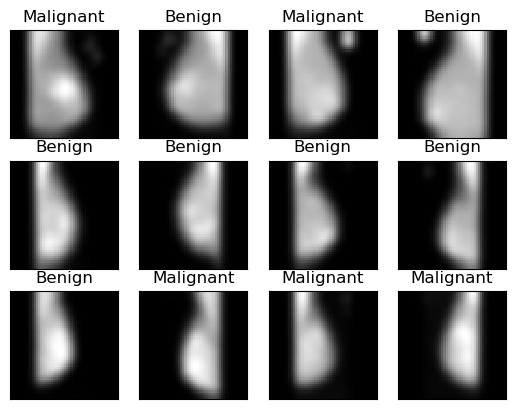

In [54]:
fig = plt.figure()
img_name = list(img_data[0])
lst = list(Y_pred_5)
index = 719
for i in range(len(img_data[:12])):
    name = str(img_name[index + 1])+".pgm"
    img = cv.resize(cv.imread(path1 + '/' + name, cv.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
    img = cv.GaussianBlur(img, (11, 11), 0)
    
    y = fig.add_subplot(3, 4, i + 1)
    
    if lst[i] == 1: str_label = 'Malignant'
    else: str_label = 'Benign'
    
    y.imshow(img, cmap='gray')
    plt.title(str_label)
    
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    index += 1
    
plt.show()

# Sample images of with the correct output

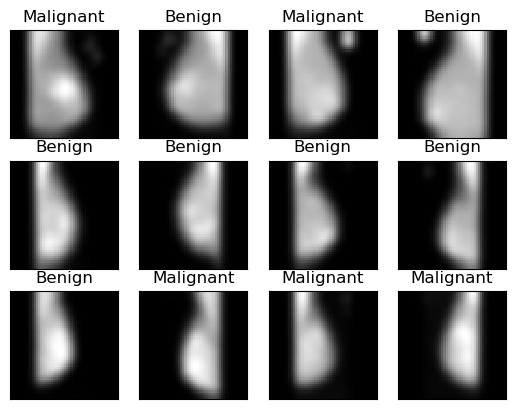

In [53]:
fig = plt.figure()
img_name = list(img_data[0])
lst = list(y_test)
index = 719
for i in range(len(img_data[:12])):
    name = str(img_name[index + 1])+".pgm"
    img = cv.resize(cv.imread(path1 + '/' + name, cv.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
    img = cv.GaussianBlur(img, (11, 11), 0)
    y = fig.add_subplot(3, 4, i + 1)
    
    if lst[i] == 1: str_label = 'Malignant'
    else: str_label = 'Benign'
    
    y.imshow(img, cmap='gray')
    plt.title(str_label)
    
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    index += 1
    
plt.show()

# Visualization of each classifier performance

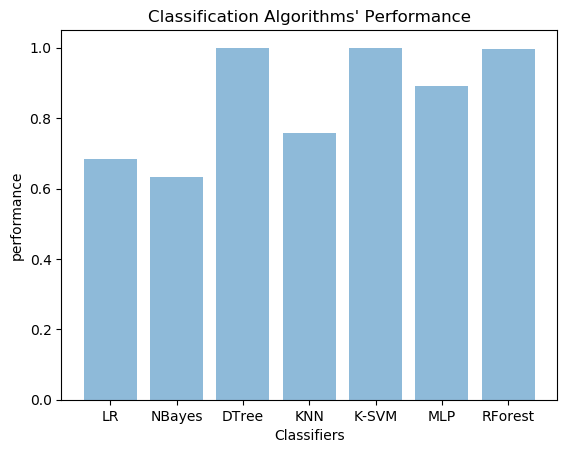

In [51]:
objects = ('LR', 'NBayes', 'DTree', 'KNN', 'K-SVM', 'MLP', 'RForest')
y_pos = np.arange(len(objects))
performance = [acc1, acc2, acc3, acc4, acc5, acc6, acc7]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifiers')
plt.ylabel('performance')
plt.title('Classification Algorithms\' Performance')

plt.show()


# Summary of Classifiers' Performance

1.	Decision Tree Algorithm — 100%
2.	Kernel SVM — 100%
3.	Random Forest Classifier — 99.58%
4.	Multi-Layer Perceptron — 89.17%
5.	k-Nearest Neighbor — 75.83%
6.	Logistic Regression — 68.33%
7.	Naive Bayes — 63.33%